## Regular EDA

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
data_100 = pd.read_csv('duplicates/hundred.tsv', sep='\t', header=None, names = ['text']) 

data_100.head(1)

,text
1,THE 19-YEAR-OLD DRIVER OF THE AMERICAN RACING ...


In [17]:
data_100.insert(0, 'column_id', range(1, len(data_100) + 1))

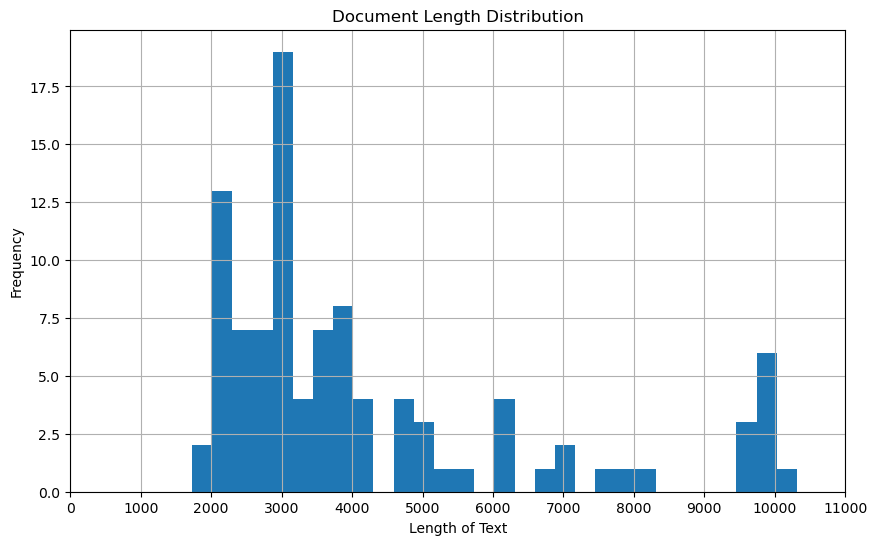

In [18]:


data_100['text_length'] = data_100['text'].apply(len)

plt.figure(figsize=(10, 6))
data_100['text_length'].hist(bins=30)

# set title
plt.title('Document Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')

# set xticks, gap as 1000
max_length = data_100['text_length'].max() 
plt.xticks(range(0, max_length + 1000, 1000))

plt.show()

# It turns out that most of text length are at about 3000 (2000-4000), and some texts still distribute sparesly at 6000, 7000, 8000, 10000


In [19]:
# unique word count
data_100['unique_words'] = data_100['text'].apply(lambda x: len(set(x.split())))
data_100['unique_words'].describe()

data_100



,column_id,text,text_length,unique_words
1,1,THE 19-YEAR-OLD DRIVER OF THE AMERICAN RACING ...,2969,282
2,2,ROB HALFORD LOOKS BACK ON PMRC: 'WE GOT ATTACK...,3978,397
3,3,MOVING TO A NEW CITY AND STARTING AT A NEW SCH...,3654,367
4,4,12TH SEPTEMBER 2015 IF WE DID ALL THE THINGS W...,4813,429
5,5,PRWEB 2015-09-01 HALFPRICESOFT.COM GIVES QB CU...,3860,271
...,...,...,...,...
96,96,"ENGLEWOOD, COLO. (AP) STILL SEARCHING FOR ANSW...",3386,359
97,97,BALLACHULISH COMMUNITY COUNCIL SECRETARY DAVE ...,2648,241
98,98,MY OWN NOTE ON THE FOLLOWING BLOG POST/ARTICLE...,9872,753
99,99,ARCHIVED. HOME MODELS GALLERY VIDEOS TOP100 CA...,7663,645


In [20]:
from collections import Counter
word_list = " ".join(data_100['text']).split()
word_freq = Counter(word_list)

print(word_freq.most_common(50))  # top 10 freq word

[('THE', 3614), ('AND', 1898), ('TO', 1845), ('OF', 1557), ('A', 1421), ('IN', 1139), ('IS', 832), ('THAT', 758), ('FOR', 757), ('ON', 600), ('I', 561), ('IT', 557), ('WE', 448), ('WITH', 435), ('BE', 383), ('YOU', 374), ('WAS', 363), ('AT', 360), ('AS', 335), ('ITS', 328), ('ARE', 306), ('HAVE', 291), ('WILL', 289), ('THIS', 279), ('FROM', 276), ('OR', 244), ('HAS', 236), ('CAN', 234), ('GET', 229), ('BUT', 227), ('BY', 225), ('MY', 221), ('ALL', 220), ('HE', 199), ('NOT', 198), ('MORE', 196), ('NEW', 193), ('ALSO', 191), ('ABOUT', 190), ('AN', 174), ('WHO', 170), ('OUR', 166), ('WHEN', 166), ('WOULD', 162), ('WHAT', 157), ('ONE', 156), ('WERE', 154), ('HIS', 150), ('LIKE', 148), ('JUST', 145)]


In [21]:
import hashlib

# MD5
def md5_hash(text):
    return hashlib.md5(text.encode()).hexdigest()

# hash value
data_100['hash'] = data_100['text'].apply(md5_hash)

# Detect simil
duplicates = data_100[data_100.duplicated('hash', keep=False)]
print(f"Total number of duplicate documents: {len(duplicates)}")


Total number of duplicate documents: 22


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

# n-gram shingles
vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char', stop_words='english')
shingles_matrix = vectorizer.fit_transform(data_100['text'])


similarity = jaccard_score(shingles_matrix[0].toarray()[0], shingles_matrix[1].toarray()[0], average='weighted')
print(f"Jaccard similarity between first two documents: {similarity}")


Jaccard similarity between first two documents: 0.7439190056015459


/Users/a123/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [27]:
import math

n = 100  # number of docs
p = 0.01  # expected mistake rate

# calculate the array size and number of hash func 
m = -(n * math.log(p)) / (math.log(2) ** 2)
k = (m / n) * math.log(2)

print(f"Recommended Bloom Filter size (m): {math.ceil(m)}")
print(f"Recommended number of hash functions (k): {math.ceil(k)}")


Recommended Bloom Filter size (m): 959
Recommended number of hash functions (k): 7


In [24]:
import time
from memory_profiler import memory_usage

start_time = time.time()
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

def run_bloom_filter():
    pass

mem_usage = memory_usage(run_bloom_filter)
print(f"Memory usage: {max(mem_usage)} MB")


Execution time: 1.2874603271484375e-05 seconds
Memory usage: 255.21875 MB


## Test for multimple dataset with different sizes

In [34]:
import time
import random

from memory_profiler import memory_usage
from datasketch import MinHash, MinHashLSH

In [32]:
# read data and split it in different sizes later
data = pd.read_csv('duplicates/thirtyk.tsv', sep='\t', header=None, names=['text'])
data.head()


,text
1,EVERYONE THAT HAS EXPERIENCED SUCCESS HAS HAD ...
2,WASHINGTON (AFP) - THE UNITED STATES' FAILURE ...
3,CORRECTING AND REPLACING BLUE PRISM IDENTIFIED...
4,PRWEB THE NEXT TAX-FILING SEASON MAY SEEM A LO...
5,WE DONT WANT LARGE NUMBER OF MUSLIMS IN OUR CO...


In [33]:
# define size
sizes = [300, 1000, 10000, 100000]

# split
datasets = {size: data.head(size) for size in sizes}

# check size
for size, subset in datasets.items():
    print(f"Dataset size {size}: {len(subset)} rows")


Dataset size 300: 300 rows
Dataset size 1000: 1000 rows
Dataset size 10000: 10000 rows
Dataset size 100000: 29994 rows


In [ ]:

class BloomFilter:
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = [0] * size

    def add(self, string):
        for seed in range(self.hash_count):
            result = hashlib.md5((string + str(seed)).encode()).hexdigest()
            index = int(result, 16) % self.size
            self.bit_array[index] = 1

    def check(self, string):
        for seed in range(self.hash_count):
            result = hashlib.md5((string + str(seed)).encode()).hexdigest()
            index = int(result, 16) % self.size
            if self.bit_array[index] == 0:
                return False
        return True

In [35]:
import time
import hashlib

class BloomFilter:
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = [0] * size

    def add(self, string):
        for seed in range(self.hash_count):
            result = hashlib.md5((string + str(seed)).encode()).hexdigest()
            index = int(result, 16) % self.size
            self.bit_array[index] = 1

    def check(self, string):
        for seed in range(self.hash_count):
            result = hashlib.md5((string + str(seed)).encode()).hexdigest()
            index = int(result, 16) % self.size
            if self.bit_array[index] == 0:
                return False
        return True

def bloom_filter_analysis(dataset, size):
    bloom = BloomFilter(size=287495, hash_count=7)

    start_time = time.time()
    for text in dataset['text']:
        bloom.add(text)
    insertion_time = time.time() - start_time

    start_time = time.time()
    for text in dataset['text']:
        bloom.check(text)
    query_time = time.time() - start_time

    return insertion_time, query_time

for size, dataset in datasets.items():
    print(f"\n==== Bloom Filter Analysis for dataset size: {size} ====")
    insertion_time, query_time = bloom_filter_analysis(dataset, size)
    print(f"Insertion time: {insertion_time:.4f} seconds")
    print(f"Query time: {query_time:.4f} seconds")



==== Bloom Filter Analysis for dataset size: 300 ====
Insertion time: 0.0204 seconds
Query time: 0.0205 seconds

==== Bloom Filter Analysis for dataset size: 1000 ====
Insertion time: 0.0600 seconds
Query time: 0.0565 seconds

==== Bloom Filter Analysis for dataset size: 10000 ====
Insertion time: 0.5928 seconds
Query time: 0.5833 seconds

==== Bloom Filter Analysis for dataset size: 100000 ====
Insertion time: 1.8131 seconds
Query time: 1.7488 seconds


In [36]:
from datasketch import MinHash, MinHashLSH
import time

# LSH function
def lsh_analysis(dataset, size):
    # create LSH, set threshold as 0.1
    lsh = MinHashLSH(threshold=0.1, num_perm=128)
    minhashes = []

    start_time = time.time()
    for i, text in enumerate(dataset['text']):
        minhash = MinHash(num_perm=128)  # shingle obj
        for shingle in text:
            minhash.update(shingle.encode('utf8'))  # generate shingle hash
        minhashes.append(minhash)
        lsh.insert(f"doc_{size}_{i}", minhash)  # insert LSH, set key as doc index
    insertion_time = time.time() - start_time

    # recording time
    start_time = time.time()
    for i in range(len(minhashes)):
        lsh.query(minhashes[i])  # query for similar doc
    query_time = time.time() - start_time

    return insertion_time, query_time

# check time of each size
for size, dataset in datasets.items():
    print(f"\n==== LSH Analysis for dataset size: {size} ====")
    insertion_time, query_time = lsh_analysis(dataset, size)
    print(f"Insertion time: {insertion_time:.4f} seconds")
    print(f"Query time: {query_time:.4f} seconds")



==== LSH Analysis for dataset size: 300 ====
Insertion time: 5.1114 seconds
Query time: 0.0997 seconds

==== LSH Analysis for dataset size: 1000 ====
Insertion time: 16.6107 seconds
Query time: 1.1519 seconds

==== LSH Analysis for dataset size: 10000 ====
Insertion time: 171.9551 seconds
Query time: 143.0207 seconds

==== LSH Analysis for dataset size: 100000 ====
Insertion time: 521.6969 seconds
Query time: 1498.9935 seconds


In [38]:
from memory_profiler import memory_usage
from datasketch import MinHash, MinHashLSH

# LSH analysis with memory usage detect
def lsh_memory_analysis(dataset, size):
    lsh = MinHashLSH(threshold=0.1, num_perm=64)
    minhashes = []

    def create_lsh():
        for i, text in enumerate(dataset['text']):
            minhash = MinHash(num_perm=64)
            for shingle in text:
                minhash.update(shingle.encode('utf8'))
            minhashes.append(minhash)

            # unique key
            key = f"doc_{size}_{i}_{time.time()}"  # add timestamp avoid time conflict
            lsh.insert(key, minhash)

    # measure memory usage
    mem_usage = memory_usage(create_lsh)

    # measure time
    start_time = time.time()
    create_lsh()
    insertion_time = time.time() - start_time

    # record query time
    start_time = time.time()
    for i in range(len(minhashes)):
        lsh.query(minhashes[i])
    query_time = time.time() - start_time

    return insertion_time, query_time, max(mem_usage)

# LSH on different sizes
for size, dataset in datasets.items():
    print(f"\n==== LSH Memory Analysis for dataset size: {size} ====")
    insertion_time, query_time, peak_memory = lsh_memory_analysis(dataset, size)
    print(f"Insertion time: {insertion_time:.4f} seconds")
    print(f"Query time: {query_time:.4f} seconds")
    print(f"Peak memory usage: {peak_memory:.2f} MB")



==== LSH Memory Analysis for dataset size: 300 ====
Insertion time: 4.6834 seconds
Query time: 0.1078 seconds
Peak memory usage: 59.89 MB

==== LSH Memory Analysis for dataset size: 1000 ====
Insertion time: 15.1224 seconds
Query time: 1.4836 seconds
Peak memory usage: 72.11 MB

==== LSH Memory Analysis for dataset size: 10000 ====
Insertion time: 156.1242 seconds
Query time: 210.8893 seconds
Peak memory usage: 610.09 MB

==== LSH Memory Analysis for dataset size: 100000 ====
Insertion time: 474.9752 seconds
Query time: 2432.4279 seconds
Peak memory usage: 225.19 MB


### False Rate Visualization for Bloom Filter

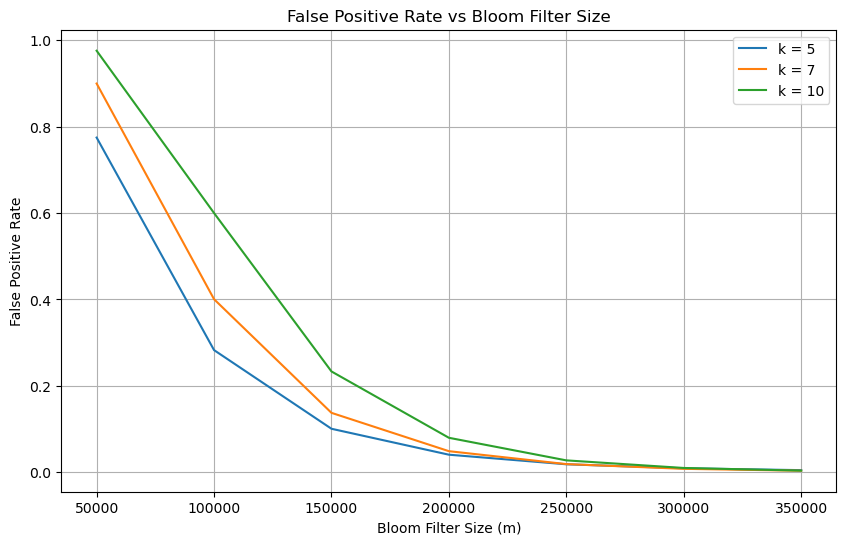

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math

# rate calculation function
def bloom_false_positive_rate(n, m, k):
    return (1 - math.exp(-k * n / m)) ** k

# data size
n = len(data)  # length of data

# different sizes and hash function
m_values = np.arange(50000, 400000, 50000) 
k_values = [5, 7, 10] # hash function numbers

# false rate curve
plt.figure(figsize=(10, 6))
for k in k_values:
    false_positive_rates = [bloom_false_positive_rate(n, m, k) for m in m_values]
    plt.plot(m_values, false_positive_rates, label=f'k = {k}')

plt.title('False Positive Rate vs Bloom Filter Size')
plt.xlabel('Bloom Filter Size (m)')
plt.ylabel('False Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('bloom_false_positive_rate.png')
plt.show()




## LSH S-curve Visualization

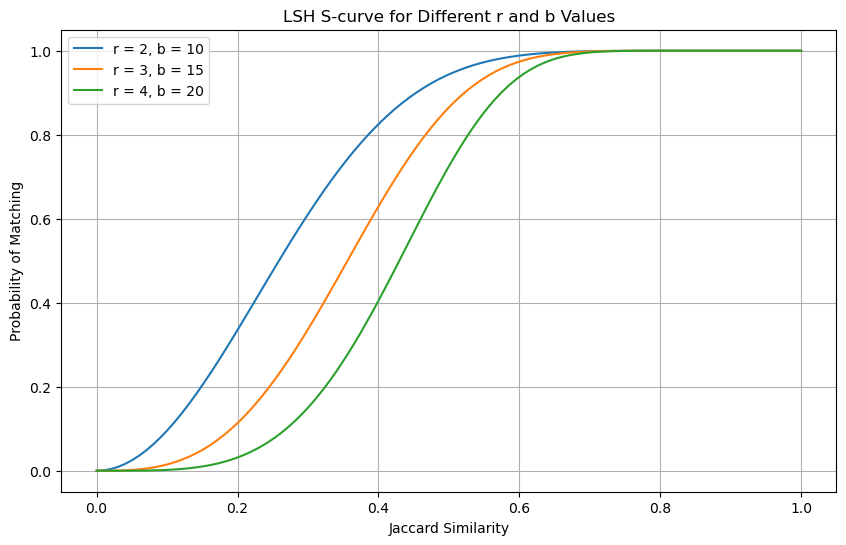

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# define s curve
def s_curve(similarity, r, b):
    return 1 - (1 - similarity ** r) ** b

# similarity range from 0 to 1
similarity_values = np.linspace(0, 1, 100)

# set r, b values
r_values = [2, 3, 4]
b_values = [10, 15, 20]

# make s curve
plt.figure(figsize=(10, 6))
for r, b in zip(r_values, b_values):
    s_values = s_curve(similarity_values, r, b)
    plt.plot(similarity_values, s_values, label=f'r = {r}, b = {b}')

plt.title('LSH S-curve for Different r and b Values')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Probability of Matching')
plt.legend()
plt.grid(True)
plt.savefig('lsh_s_curve.png')
plt.show()
